In [1]:
import spacy
import pandas as pd
from itertools import combinations as combs
from spacy.matcher import Matcher
from spacy import displacy

import nltk

import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Dropout, SpatialDropout1D
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import load_model

from collections import Counter
import text_normalizer as tn
import model_evaluation_utils as meu

from keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder

## Data Pipeline

In [2]:
nlp = spacy.load('en_core_web_sm')

doc1  = nlp(u'An Englishman, a Scotsman and an Irishman walk into a bar. The Englishman wanted to go so they all had to leave. #Brexitjokes')
doc2  = nlp(u'Why do we need any colour passport? We should just be able to shout, “British! Less of your nonsense!” and stroll straight through.')
doc3  = nlp(u'Q: With Britain leaving the EU how much space was created? A: Exactly 1GB')
doc4  = nlp(u'VOTERS: we want to give a boat a ridiculous name UK: no VOTERS: we want to break up the EU and trash the world economy UK: fine')
doc5  = nlp(u'#BrexitJokes How did the Brexit chicken cross the road? \"I never said there was a road. Or a chicken\".')
doc6  = nlp(u'After #brexit, when rapper 50 cent performs in GBR he\'ll appear as 10.00 pounds. #brexitjokes')
doc7  = nlp(u'I long for the simpler days when #Brexit was just a term for leaving brunch early.')
doc8  = nlp(u'Say goodbye to croissants, people. Delicious croissants. We\'re stuck with crumpets FOREVER.')
doc9  = nlp(u'Hello, I am from Britain, you know, the one that got tricked by a bus')
doc10 = nlp(u'How many Brexiteers does it take to change a light bulb? None, they are all walked out because they didn’t like the way the electrician did it.')

docs = [
    doc1,
    doc2,
    doc3,
    doc4,
    doc5,
    doc6,
    doc7,
    doc8,
    doc9,
    doc10]

In [26]:
#Creating DF for LSTM
tweets = np.array([
    ["An Englishman, a Scotsman and an Irishman walk into a bar. The Englishman wanted to go so they all had to leave. #Brexitjokes"],
    ["Why do we need any colour passport? We should just be able to shout, “British! Less of your nonsense!” and stroll straight through."],
    ["Q: With Britain leaving the EU how much space was created? A: Exactly 1GB"],
    ["VOTERS: we want to give a boat a ridiculous name UK: no VOTERS: we want to break up the EU and trash the world economy UK: fine"],
    ["#BrexitJokes How did the Brexit chicken cross the road? \"I never said there was a road. Or a chicken\"."],
    ["After #brexit, when rapper 50 cent performs in GBR he'll appear as 10.00 pounds. #brexitjokes"],
    ["I long for the simpler days when #Brexit was just a term for leaving brunch early."],
    ["Say goodbye to croissants, people. Delicious croissants. We're stuck with crumpets FOREVER."],
    ["Hello, I am from Britain, you know, the one that got tricked by a bus"],
    ["How many Brexiteers does it take to change a light bulb? None, they are all walked out because they didn’t like the way the electrician did it."]])

tweet_df = pd.DataFrame(tweets, columns=['tweet_content'])
tweet_df.head()

# Removing Stop words
stop_words = nltk.corpus.stopwords.words('english')
stop_words.remove('no')
stop_words.remove('but')
stop_words.remove('not')

___

## Part of Speach Tagging

In [37]:
tweet_no = 1
for doc in docs:
    print(f'Tweet: {tweet_no}')
    for token in doc:
        print(f'{token.text:{10}} - {token.pos_:{10}} - {token.tag_:{10}} - {spacy.explain(token.tag_)}')
    tweet_no += 1
    

Tweet: 1
An         - DET        - DT         - determiner
Englishman - PROPN      - NNP        - noun, proper singular
,          - PUNCT      - ,          - punctuation mark, comma
a          - DET        - DT         - determiner
Scotsman   - PROPN      - NNP        - noun, proper singular
and        - CCONJ      - CC         - conjunction, coordinating
an         - DET        - DT         - determiner
Irishman   - PROPN      - NNP        - noun, proper singular
walk       - NOUN       - NN         - noun, singular or mass
into       - ADP        - IN         - conjunction, subordinating or preposition
a          - DET        - DT         - determiner
bar        - NOUN       - NN         - noun, singular or mass
.          - PUNCT      - .          - punctuation mark, sentence closer
The        - DET        - DT         - determiner
Englishman - PROPN      - NNP        - noun, proper singular
wanted     - VERB       - VBD        - verb, past tense
to         - PART       - TO       

In [42]:
# POS Counts
tweet_no = 1
for doc in docs:
    print(f'Tweet: {tweet_no}')
    POS_counts = doc.count_by(spacy.attrs.POS)
    for k,v in sorted(POS_counts.items()):
        print(f'{k}: {doc.vocab[k].text:{5}} {v}')
    
    print('\n')
    tweet_no += 1

Tweet: 1
85: ADP   1
86: ADV   1
89: CCONJ 1
90: DET   6
92: NOUN  3
94: PART  2
95: PRON  1
96: PROPN 4
97: PUNCT 3
99: SYM   1
100: VERB  4


Tweet: 2
84: ADJ   3
85: ADP   1
86: ADV   4
87: AUX   2
89: CCONJ 1
90: DET   1
92: NOUN  3
94: PART  1
95: PRON  3
97: PUNCT 7
100: VERB  4


Tweet: 3
84: ADJ   1
85: ADP   1
86: ADV   2
87: AUX   1
90: DET   2
92: NOUN  2
93: NUM   1
96: PROPN 3
97: PUNCT 3
100: VERB  2


Tweet: 4
84: ADJ   2
85: ADP   1
89: CCONJ 1
90: DET   5
92: NOUN  6
94: PART  2
95: PRON  2
96: PROPN 3
97: PUNCT 4
100: VERB  5


Tweet: 5
86: ADV   2
87: AUX   2
89: CCONJ 1
90: DET   4
92: NOUN  5
95: PRON  2
96: PROPN 2
97: PUNCT 5
100: VERB  2


Tweet: 6
85: ADP   3
86: ADV   1
87: AUX   1
92: NOUN  8
93: NUM   2
95: PRON  1
96: PROPN 1
97: PUNCT 2
100: VERB  1


Tweet: 7
84: ADJ   1
85: ADP   2
86: ADV   4
90: DET   2
92: NOUN  4
95: PRON  1
96: PROPN 1
97: PUNCT 1
100: VERB  2


Tweet: 8
84: ADJ   2
85: ADP   2
86: ADV   1
92: NOUN  5
95: PRON  1
97: PUNCT 4
100: VE

In [55]:
# Visualising POS
options = {
    'distance':95,
    'compact':'True'
}

for doc in docs:
    spans = list(doc.sents)
    displacy.render(spans,style='dep',jupyter=True, options = options)

___

## Named Entity Recognition

In [56]:
def show_ents(doc):
    no_ents = 0
    if doc.ents:
        for ent in doc.ents:
            print(f'{ent.text} - {ent.label_} - {spacy.explain(ent.label_)}')
            no_ents += 1
        print(f'Total number of entities: {no_ents}')
    else:
        print('No entites found')

In [57]:
tweet_no = 1
for doc in docs:
    print(f'Tweet: {tweet_no}')
    show_ents(doc)
    print('\n')
    tweet_no += 1

Tweet: 1
Scotsman - PERSON - People, including fictional
Irishman - NORP - Nationalities or religious or political groups
Englishman - PERSON - People, including fictional
Total number of entities: 3


Tweet: 2
British - NORP - Nationalities or religious or political groups
Total number of entities: 1


Tweet: 3
Britain - GPE - Countries, cities, states
EU - ORG - Companies, agencies, institutions, etc.
Total number of entities: 2


Tweet: 4
UK - GPE - Countries, cities, states
EU - ORG - Companies, agencies, institutions, etc.
Total number of entities: 2


Tweet: 5
Brexit - PERSON - People, including fictional
Total number of entities: 1


Tweet: 6
50 cent - MONEY - Monetary values, including unit
10.00 pounds - MONEY - Monetary values, including unit
Total number of entities: 2


Tweet: 7
the simpler days - DATE - Absolute or relative dates or periods
Brexit - PERSON - People, including fictional
Total number of entities: 2


Tweet: 8
FOREVER - WORK_OF_ART - Titles of books, songs, e

In [33]:
tweet_no = 1
for doc in docs:
    print(f'Tweet: {tweet_no}')
    displacy.render(doc, style="ent")
    tweet_no += 1

Tweet: 1


Tweet: 2


Tweet: 3


Tweet: 4


Tweet: 5


Tweet: 6


Tweet: 7


Tweet: 8


Tweet: 9


Tweet: 10


___

## Feature Extraction

In [91]:
tweet_df.isnull().sum() #delete at a later date

tweet_content    0
dtype: int64

In [10]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer

In [12]:
tfidf = TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1,2))

In [17]:
doc1  = ('An Englishman, a Scotsman and an Irishman walk into a bar. The Englishman wanted to go so they all had to leave. #Brexitjokes')
doc2  = ('Why do we need any colour passport? We should just be able to shout, “British! Less of your nonsense!” and stroll straight through.')
doc3  = ('Q: With Britain leaving the EU how much space was created? A: Exactly 1GB')
doc4  = ('VOTERS: we want to give a boat a ridiculous name UK: no VOTERS: we want to break up the EU and trash the world economy UK: fine')
doc5  = ('#BrexitJokes How did the Brexit chicken cross the road? \"I never said there was a road. Or a chicken\".')
doc6  = ('After #brexit, when rapper 50 cent performs in GBR he\'ll appear as 10.00 pounds. #brexitjokes')
doc7  = ('I long for the simpler days when #Brexit was just a term for leaving brunch early.')
doc8  = ('Say goodbye to croissants, people. Delicious croissants. We\'re stuck with crumpets FOREVER.')
doc9  = ('Hello, I am from Britain, you know, the one that got tricked by a bus')
doc10 = ('How many Brexiteers does it take to change a light bulb? None, they are all walked out because they didn’t like the way the electrician did it.')

fe_docs = [
    doc1,
    doc2,
    doc3,
    doc4,
    doc5,
    doc6,
    doc7,
    doc8,
    doc9,
    doc10]

In [21]:
features = tfidf.fit_transform(fe_docs)

In [22]:
fe_df = pd.DataFrame(features.todense(),columns=tfidf.get_feature_names())

In [23]:
fe_df

,all,and,brexit,brexitjokes,britain,did,eu,how,just,leaving,the eu,they,to,was,we,when,with
0,0.427075,0.373640,0.000000,0.373640,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.427075,0.596656,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.379486,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.433757,0.000000,0.000000,0.000000,0.302996,0.000000,0.758972,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.391305,0.000000,0.391305,0.342346,0.000000,0.391305,0.391305,0.000000,0.000000,0.342346,0.000000,0.000000,0.391305
3,0.000000,0.313682,0.000000,0.000000,0.000000,0.000000,0.358542,0.000000,0.000000,0.000000,0.358542,0.000000,0.500911,0.000000,0.627365,0.000000,0.000000
4,0.000000,0.000000,0.434107,0.434107,0.000000,0.496189,0.000000,0.434107,0.000000,0.000000,0.000000,0.000000,0.000000,0.434107,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.549943,0.549943,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.628591,0.000000
6,0.000000,0.000000,0.411017,0.000000,0.000000,0.000000,0.000000,0.000000,0.469798,0.469798,0.000000,0.000000,0.000000,0.411017,0.000000,0.469798,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.465343,0.000000,0.582818,0.000000,0.666168
8,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.371304,0.000000,0.000000,0.000000,0.000000,0.371304,0.000000,0.324847,0.000000,0.000000,0.000000,0.742609,0.259370,0.000000,0.000000,0.000000,0.000000


___

## Sentiment Analysis

In [29]:
# Load pre-trained model
model = load_model('LSTM_model.h5')

In [27]:
norm_tweets = tn.normalize_corpus(tweet_df['tweet_content'], stopwords=stop_words)
tokenized_tweets  = [tn.tokenizer.tokenize(text) for text in norm_tweets]

# build word to index vocabulary
token_counter = Counter([token for review in tokenized_tweets for token in review])
vocab_map     = {item[0]: index+1 for index, item in enumerate(dict(token_counter).items())}
max_index     = np.max(list(vocab_map.values()))

vocab_map['PAD_INDEX']       = 0
vocab_map['NOT_FOUND_INDEX'] = max_index+1

vocab_size    = len(vocab_map)

# view vocabulary size and part of the vocabulary map
print('Vocabulary Size:', vocab_size)
print('Sample slice of vocabulary map:', dict(list(vocab_map.items())))

#get max length of train corpus and initialize label encoder
le          = LabelEncoder()
num_classes = 2 # positive -> 1, negative -> 0
max_len     = np.max([len(review) for review in tokenized_tweets])


## Test reviews data corpus
# Convert tokenized text reviews to numeric vectors
tweet_ready = [[vocab_map[token] for token in tokenized_review] for tokenized_review in tokenized_tweets]
tweet_ready = sequence.pad_sequences(tweet_ready, maxlen=max_len) # pad 


# view vector shapes
print('Max length of tweet review vectors:', max_len)
print('Tweet vectors shape:', tweet_ready.shape)

Vocabulary Size: 84
Sample slice of vocabulary map: {'englishman': 1, 'scotsman': 2, 'irishman': 3, 'walk': 4, 'bar': 5, 'want': 6, 'go': 7, 'leave': 8, 'brexitjoke': 9, 'need': 10, 'colour': 11, 'passport': 12, 'able': 13, 'shout': 14, 'british': 15, 'less': 16, 'nonsense': 17, 'stroll': 18, 'straight': 19, 'q': 20, 'britain': 21, 'eu': 22, 'much': 23, 'space': 24, 'create': 25, 'exactly': 26, 'gb': 27, 'voter': 28, 'give': 29, 'boat': 30, 'ridiculous': 31, 'name': 32, 'uk': 33, 'no': 34, 'break': 35, 'trash': 36, 'world': 37, 'economy': 38, 'fine': 39, 'brexitjokes': 40, 'brexit': 41, 'chicken': 42, 'cross': 43, 'road': 44, 'never': 45, 'say': 46, 'rapper': 47, 'cent': 48, 'perform': 49, 'gbr': 50, 'appear': 51, 'pound': 52, 'long': 53, 'simple': 54, 'day': 55, 'term': 56, 'brunch': 57, 'early': 58, 'goodbye': 59, 'croissant': 60, 'people': 61, 'delicious': 62, 'stick': 63, 'crumpet': 64, 'forever': 65, 'hello': 66, 'know': 67, 'one': 68, 'got': 69, 'trick': 70, 'bus': 71, 'many': 72

In [30]:
my_pred_test = model.predict(tweet_ready)

In [31]:
pred_score = [1 if p > 0.5 else 0 for p in my_pred_test]
pred_sent = ['Positive' if p > 0.5 else 'Negative' for p in my_pred_test]

In [32]:
for i in range(len(pred_score)):
    print(f'Tweet {i+1}:\nActual Score: {my_pred_test[i]} - Score: {pred_score[i]} - Sentiment: {pred_sent[i]}')

Tweet 1:
Actual Score: [0.5145975] - Score: 1 - Sentiment: Positive
Tweet 2:
Actual Score: [0.9946981] - Score: 1 - Sentiment: Positive
Tweet 3:
Actual Score: [0.78269374] - Score: 1 - Sentiment: Positive
Tweet 4:
Actual Score: [0.8127065] - Score: 1 - Sentiment: Positive
Tweet 5:
Actual Score: [0.06928542] - Score: 0 - Sentiment: Negative
Tweet 6:
Actual Score: [0.4466458] - Score: 0 - Sentiment: Negative
Tweet 7:
Actual Score: [0.37085027] - Score: 0 - Sentiment: Negative
Tweet 8:
Actual Score: [0.92935675] - Score: 1 - Sentiment: Positive
Tweet 9:
Actual Score: [0.91288126] - Score: 1 - Sentiment: Positive
Tweet 10:
Actual Score: [0.2754283] - Score: 0 - Sentiment: Negative


___

## Tweet Similarity Scoring

### Document Similarity

In [28]:
doc_df = pd.DataFrame()

for each_pair in id_combs:
    doc_similarity = docs[each_pair[0]-1].similarity(docs[each_pair[1]-1])
    doc_results = {
        'tweet1': int(each_pair[0]),
        'tweet2': int(each_pair[1]),
        'similarity': doc_similarity,
        'text 1': docs[each_pair[0]-1],
        'text 2': docs[each_pair[1]-1]
    }
    
    doc_df = doc_df.append(doc_results, ignore_index=True)

<ipython-input-28-7d924ec05226>:4: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Doc.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  doc_similarity = docs[each_pair[0]-1].similarity(docs[each_pair[1]-1])


In [29]:
doc_df['tweet1'] = doc_df['tweet1'].astype(int)
doc_df['tweet2'] = doc_df['tweet2'].astype(int)
doc_df.head()

,similarity,text 1,text 2,tweet1,tweet2
0,0.246874,"(An, Englishman, ,, a, Scotsman, and, an, Iris...","(Why, do, we, need, any, colour, passport, ?, ...",1,2
1,0.338287,"(An, Englishman, ,, a, Scotsman, and, an, Iris...","(Q, :, With, Britain, leaving, the, EU, how, m...",1,3
2,0.490278,"(An, Englishman, ,, a, Scotsman, and, an, Iris...","(VOTERS, :, we, want, to, give, a, boat, a, ri...",1,4
3,0.575611,"(An, Englishman, ,, a, Scotsman, and, an, Iris...","(#, BrexitJokes, How, did, the, Brexit, chicke...",1,5
4,0.198380,"(An, Englishman, ,, a, Scotsman, and, an, Iris...","(After, #, brexit, ,, when, rapper, 50, cent, ...",1,6


In [30]:
doc_df_ordered = doc_df.sort_values(by=['similarity'], ascending=False)
doc_df_ordered.head(10)

,similarity,text 1,text 2,tweet1,tweet2
34,0.576191,"(#, BrexitJokes, How, did, the, Brexit, chicke...","(How, many, Brexiteers, does, it, take, to, ch...",5,10
3,0.575611,"(An, Englishman, ,, a, Scotsman, and, an, Iris...","(#, BrexitJokes, How, did, the, Brexit, chicke...",1,5
16,0.490846,"(Why, do, we, need, any, colour, passport, ?, ...","(How, many, Brexiteers, does, it, take, to, ch...",2,10
2,0.490278,"(An, Englishman, ,, a, Scotsman, and, an, Iris...","(VOTERS, :, we, want, to, give, a, boat, a, ri...",1,4
14,0.489872,"(Why, do, we, need, any, colour, passport, ?, ...","(Say, goodbye, to, croissants, ,, people, ., D...",2,8
8,0.462386,"(An, Englishman, ,, a, Scotsman, and, an, Iris...","(How, many, Brexiteers, does, it, take, to, ch...",1,10
11,0.458674,"(Why, do, we, need, any, colour, passport, ?, ...","(#, BrexitJokes, How, did, the, Brexit, chicke...",2,5
18,0.456565,"(Q, :, With, Britain, leaving, the, EU, how, m...","(#, BrexitJokes, How, did, the, Brexit, chicke...",3,5
20,0.439537,"(Q, :, With, Britain, leaving, the, EU, how, m...","(I, long, for, the, simpler, days, when, #, Br...",3,7
7,0.406573,"(An, Englishman, ,, a, Scotsman, and, an, Iris...","(Hello, ,, I, am, from, Britain, ,, you, know,...",1,9


### Term Similarity

In [3]:
spans = {}

In [4]:
for j,doc in enumerate(docs):
    named_entity_span = [doc[i].text for i in range(len(doc)) if doc[i].ent_type != 0]
    print(named_entity_span)
    named_entity_span = ' '.join(named_entity_span)
    named_entity_span = nlp(named_entity_span)
    spans.update({j:named_entity_span})

['Scotsman', 'Irishman', 'Englishman']
['British']
['Britain', 'EU']
['UK', 'EU']
['Brexit']
['50', 'cent', '10.00', 'pounds']
['the', 'simpler', 'days', 'Brexit']
['FOREVER']
['Britain']
['Brexiteers']


In [7]:
df = pd.DataFrame()

tweet_id = [i for i in range(1,11)]
id_combs = list(combs(tweet_id, 2))

for each_pair in id_combs:
    similarity = spans[each_pair[0]-1].similarity(spans[each_pair[1]-1])
    #print(f'doc{each_pair[0]} is similar to doc{each_pair[1]} by: {similarity}') #Un-comment if you want to see individual scores printed.
    results = {
        'tweet1': int(each_pair[0]),
        'tweet2': int(each_pair[1]),
        'similarity': similarity,
        'tweet1 NE Span': spans[each_pair[0]-1],
        'tweet2 NE Span': spans[each_pair[1]-1]
    }
    
    df = df.append(results, ignore_index=True)

<ipython-input-7-cfc05c34a82a>:7: UserWarning: [W007] The model you're using has no word vectors loaded, so the result of the Doc.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  similarity = spans[each_pair[0]-1].similarity(spans[each_pair[1]-1])


In [8]:
# Chaning Data Types
df['tweet1'] = df['tweet1'].astype(int)
df['tweet2'] = df['tweet2'].astype(int)

In [12]:
# Saving to/loading from CSV
#df = pd.read_csv('similarity_scores_v2.csv') #Uncomment to load.
#df.to_csv('similarity_scores_v2.csv') #Uncomment to resave.

In [9]:
df_ordered = df.sort_values(by=['similarity'], ascending=False)

In [10]:
# Display the Top 10 Simialr Combinations 
df_ordered.head(10)

,similarity,tweet1,tweet1 NE Span,tweet2,tweet2 NE Span
17,0.857896,3,"(Britain, EU)",4,"(UK, EU)"
1,0.788178,1,"(Scotsman, Irishman, Englishman)",3,"(Britain, EU)"
33,0.771924,5,(Brexit),9,(Britain)
2,0.720223,1,"(Scotsman, Irishman, Englishman)",4,"(UK, EU)"
18,0.688950,3,"(Britain, EU)",5,(Brexit)
22,0.646520,3,"(Britain, EU)",9,(Britain)
24,0.598866,4,"(UK, EU)",5,(Brexit)
16,0.549264,2,(British),10,(Brexiteers)
7,0.510660,1,"(Scotsman, Irishman, Englishman)",9,(Britain)
3,0.510251,1,"(Scotsman, Irishman, Englishman)",5,(Brexit)


In [11]:
# Display the Bottom 10 Simialr Combinations 
df_ordered.tail(10)

,similarity,tweet1,tweet1 NE Span,tweet2,tweet2 NE Span
6,0.198919,1,"(Scotsman, Irishman, Englishman)",8,(FOREVER)
30,0.186382,5,(Brexit),6,"(50, cent, 10.00, pounds)"
39,0.185533,7,"(the, simpler, days, Brexit)",8,(FOREVER)
41,0.124216,7,"(the, simpler, days, Brexit)",10,(Brexiteers)
19,0.123947,3,"(Britain, EU)",6,"(50, cent, 10.00, pounds)"
36,0.097287,6,"(50, cent, 10.00, pounds)",8,(FOREVER)
4,0.075894,1,"(Scotsman, Irishman, Englishman)",6,"(50, cent, 10.00, pounds)"
38,0.065650,6,"(50, cent, 10.00, pounds)",10,(Brexiteers)
25,0.036557,4,"(UK, EU)",6,"(50, cent, 10.00, pounds)"
12,-0.025753,2,(British),6,"(50, cent, 10.00, pounds)"


___

## Utterence Pattern Matching

In [13]:
def dep_pattern(doc):
    for i in range(len(doc)-1):
        if doc[i].dep_ == 'nsubj' and doc[i+1].dep_ == 'aux' and doc[i+2].dep_ == 'ROOT':
            for tok in doc[i+2].children:
                if tok.dep_ == 'dobj':
                    return True
    else:
        return False

In [16]:
for i in docs:
    if dep_pattern(i):
        print(f'Found in: {i}')
    else:
        print('Not Found')

Not Found
Not Found
Not Found
Not Found
Not Found
Found in: After #brexit, when rapper 50 cent performs in GBR he'll appear as 10.00 pounds. #brexitjokes
Not Found
Not Found
Not Found
Not Found


___

## Finding Word Sequence Patterns

In [30]:
matcher = Matcher(nlp.vocab)
pattern = [{
    'DEP':"nsubj"}, 
    {"DEP":"aux"}, 
    {"DEP":"ROOT"}
    ]

matcher.add("NsubjAuxRoot", [pattern])

tweet_no = 1

for doc in docs:
    matches = matcher(doc)
    print(f'Tweet: {tweet_no}')
    for match_id, start, end in matches:
        span = doc[start:end]
        print(f"Span: {span.text}")
        print(f"The position in the doc are: {start} - {end}\n")
    else:
        print("None found.\n")
    tweet_no += 1

Tweet: 1
None found.

Tweet: 2
None found.

Tweet: 3
None found.

Tweet: 4
None found.

Tweet: 5
None found.

Tweet: 6
Span: he'll appear
The position in the doc are: 11 - 14

None found.

Tweet: 7
None found.

Tweet: 8
None found.

Tweet: 9
None found.

Tweet: 10
None found.



___

## Topic Modelling

In [89]:
## Is this needed?

___

## Key Phrases

In [1]:
def keyphrase(doc):
    for t in doc:
        if t.dep_ == 'probj' and (t.pos_ == 'NOUN' or t.pos_ == "PROPN"):
            return (' '.join([child.text for child in t.lefts]) + ' ' + t.text).lstrip()
    for t in reversed(doc):
        if t.dep_ == 'nsubj' and (t.pos_ == 'NOUN' or t.pos_ == 'PROPN'):
            return t.text + ' ' + t.head.text
    for t in reversed(doc):
        if t.dep_ == 'dobj' and (t.pos_ == 'NOUN' or t.pos_ == 'PROPN'):
            return t.head.text + ' ' + 'ing' + ' ' + t.text
    return False


In [5]:
tweet_no = 1
for doc in docs:
    print(keyphrase(doc))
    tweet_no += 1

Englishman wanted
need ing passport
Britain leaving
trash ing UK
chicken cross
appear ing performs
Brexit was
Say ing goodbye
False
electrician did


___

# Result Analysis

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.colors import LogNorm

## Combination Distribution

In [3]:
df = pd.read_csv('Comparison Times Tracker.csv', index_col=0)

In [11]:
df.head(10)

,1,2,3,4,5,6,7,8,9,10
1,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0
3,3,2,0,0,0,0,0,0,0,0
4,2,7,6,0,0,0,0,0,0,0
5,8,2,5,4,0,0,0,0,0,0
6,7,4,4,4,3,0,0,0,0,0
7,5,7,4,3,6,1,0,0,0,0
8,6,3,6,4,5,4,4,0,0,0
9,2,6,6,3,3,7,8,4,0,0
10,4,6,4,6,5,6,3,4,2,0


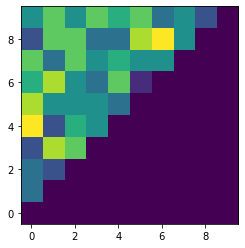

In [13]:
plt.imshow(np.array(df.values.tolist()).astype('float'),interpolation ='nearest', origin ='lower')

In [14]:
df.shape

(10, 10)

AttributeError: module 'matplotlib.pyplot' has no attribute 'set_xticklabels'

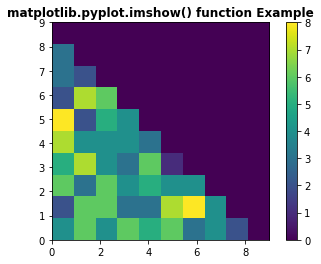

In [34]:
y, x = np.mgrid[slice(0, 10),
                slice(0, 10)]

c = plt.imshow(df,
                 extent =[x.min(), x.max(), y.min(), y.max()],
                    interpolation ='nearest')
plt.colorbar(c)
  
plt.title('matplotlib.pyplot.imshow() function Example', 
                                     fontweight ="bold")
#plt.set_xticks(np.arange(len(tweet_id)))
#plt.set_yticks(np.arange(len(tweet_id)))
# ... and label them with the respective list entries
plt.set_xticklabels(tweet_id)
plt.set_yticklabels(tweet_id)
plt.show()

<ipython-input-4-0c9e934874fe>:10: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("jet"))
  cmap.set_bad(color='white')


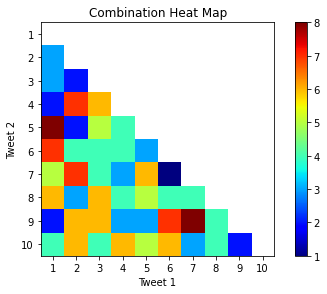

In [4]:
tweet_id = ["1", "2", "3", "4",
              "5", "6", "7","8","9","10"]

results = df

results[results==0] = np.nan

fig, ax = plt.subplots()
cmap = plt.cm.jet
cmap.set_bad(color='white')
im = ax.imshow(results, cmap=cmap)

# We want to show all ticks...
ax.set_xticks(np.arange(len(tweet_id)))
ax.set_yticks(np.arange(len(tweet_id)))
# ... and label them with the respective list entries
ax.set_xticklabels(tweet_id)
ax.set_yticklabels(tweet_id)
plt.colorbar(im)

ax.set_title("Combination Heat Map")
fig.tight_layout()
plt.xlabel("Tweet 1")
plt.ylabel("Tweet 2")
plt.show()

In [8]:
win_df = pd.read_csv('Comparison Win Tracker.csv', index_col=0)

In [9]:
win_df.head()

,1,2,3,4,5,6,7,8,9,10
1,-1,1,1,1,1,1,0,3,1,0
2,2,-1,2,6,2,3,3,1,4,2
3,2,0,-1,2,1,0,0,2,1,0
4,1,1,4,-1,1,2,1,1,1,2
5,5,0,4,3,-1,1,1,3,2,5


<ipython-input-10-fa1d30e08a5b>:10: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("jet"))
  cmap.set_bad(color='white')


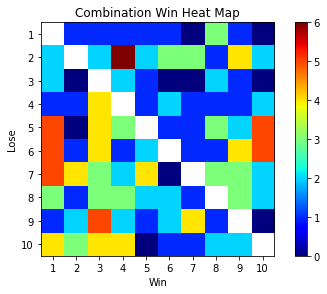

In [10]:
tweet_id = ["1", "2", "3", "4",
              "5", "6", "7","8","9","10"]

results = win_df

results[results==-1] = np.nan

fig, ax = plt.subplots()
cmap = plt.cm.jet
cmap.set_bad(color='white')
im = ax.imshow(results, cmap=cmap)

# We want to show all ticks...
ax.set_xticks(np.arange(len(tweet_id)))
ax.set_yticks(np.arange(len(tweet_id)))
# ... and label them with the respective list entries
ax.set_xticklabels(tweet_id)
ax.set_yticklabels(tweet_id)
plt.colorbar(im)

ax.set_title("Combination Win Heat Map")
fig.tight_layout()
plt.xlabel("Win")
plt.ylabel("Lose")
plt.show()